## TEMPORARY HELPING FUNCTIONS 

A temporary Jupyter Notebook for fast writing and testing some useful function

In [1]:
import json
import gzip
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import fisher_exact
from wordcloud import WordCloud

UniRef90_P43582: MAQSKSNPPQVPSGWKAVFDDEYQTWYYVDLSTNSSQWEPPRGTTWPRPKGPPPGVNNEKSSRQQADQAPPPYSSQSTPQVQAGAQAQQPRYYQPQQPQYPQYPQQQRYYPQQAPMPAAAPQQAYYGTAPSTSKGSGHGGAMMGGLLGVGAGLLGGAMLEHAFDDHNYDGPDTVVVENNYYGDDAGGSDGGFDDAGGFDGGFDDGFDGSDF

UniRef90_J8Q8J2: MAQSKSNPPQVPSGWKAVFDDEYQTWFYVDLSTNNSQWEPPKGASFPRPKGPPPAANNEKTSRQQGDQAPPPYSAQSRTQPQPQAQQAQQGRYYQPQQPQYPQQPQQQSYYPQQVPMAAAAAPQQGYYGATPTAAKSSGRSGAMMGGLLGVGAGLLGGAMLEHAFDDHSHGGPGPVVENNYYGDDNGGGFGGPFDGGFDGEFDGGFDGGDF

UniRef90_J5RH20: MAQSKGNPPQVPSGWKAVFDDEYQTWFYVNLSTNSSQWEPPKGTTWPRPKGPPPGVNNEKSSRQEVDQAPPPYSSQSRAQPQAPAQQTRYYQPQQSQYPQQPQQQRYYQQQAPMAAAAPQQAYYGTTPSAAKSSGHGGAMMGGLLGVGAGLLGGAMLEHAFDDHDNYDQPDNVVVENNYYGDDGGFDGGFDGGFDGGDF

Index of sequence with length greater than 1000:
[63, 157, 187, 189]


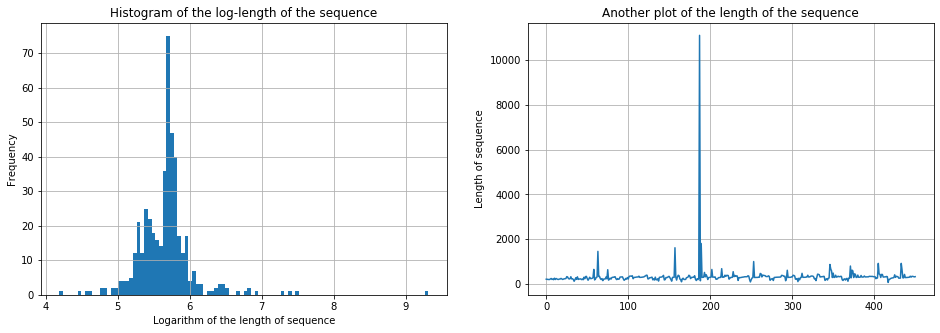

In [3]:
"""
Take a path of a fasta file and return a dict {id: sequence} (tuned on the example of uniref90)
"""
def fasta_to_dict(path): 
    with open(path, 'r') as file:
        lines = [line for line in file]
   
    # Get two separate list
    ids = []
    chain = []
    temp=[]
    for n, l in enumerate(lines):
        if l[0] == '>':
            sentence = l.split()[0]
            ids.append(sentence[1:]) # We take only the first part as identifier
            if n>1:
                chain.append(temp)
                temp = []
        else:
            temp.append(l[:-1]) # We remove the '\n' at the end
    chain.append(temp)
    # Get a dictionary
    dict_fasta = {key: value for key, value in zip(ids, chain)}
    for key in dict_fasta:
        temp = ''
        n = len(dict_fasta[key])
        for i in range(n):
            temp += dict_fasta[key][i]
        dict_fasta[key] = temp

    return dict_fasta


"""
Example: we use data\\blast_uniref90_reduced.fasta as input
"""
# Get the dictionary
my_result = fasta_to_dict(path = 'data/blast.fasta')
# Print some lines
for n, key in enumerate(my_result.keys()):
    print('{}: {}'.format(key, my_result[key]), end='\n\n')
    if n >= 2:
        break
# Get the lenght of the sequences
length = [len(my_result[key]) for key in my_result]
# Get index of sequence with length greater than l
l = 1000
print('Index of sequence with length greater than {}:\n{}'.format(l, list(np.where([np.array(length) > l])[1])))
# Display distribution
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].hist(np.log(length), bins=100)
ax[0].grid()
ax[0].set_title('Histogram of the log-length of the sequence')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Logarithm of the length of sequence')
ax[1].plot(length)
ax[1].grid()
ax[1].set_title('Another plot of the length of the sequence')
ax[1].set_ylabel('Length of sequence')
plt.show()

In [4]:
"""
From a dict of id: sequence (see fasta_to_dict function) get a pandas dataframe from allignment
"""
def dict_to_df(my_dict):
    # Init variables
    max_length = np.max([len(my_dict[key]) for key in my_dict])
    df = pd.DataFrame()

    # Insert key: values
    for key in my_dict:
        # Split the value in single char
        value = [char for char in my_dict[key]]
        # Insert None until max_length is reached
        for i in range(len(value), max_length):
            value.append(None)
        df[key] = value
        
    # Return the transpose
    df = df.transpose()
    return df
    
df = dict_to_df(my_dict=my_result)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11096,11097,11098,11099,11100,11101,11102,11103,11104,11105
UniRef90_P43582,M,A,Q,S,K,S,N,P,P,Q,...,None,None,None,None,None,None,None,None,None,None
UniRef90_J8Q8J2,M,A,Q,S,K,S,N,P,P,Q,...,None,None,None,None,None,None,None,None,None,None
UniRef90_J5RH20,M,A,Q,S,K,G,N,P,P,Q,...,None,None,None,None,None,None,None,None,None,None
UniRef90_A0A0L8RJY2,M,G,Q,S,K,S,N,P,P,Q,...,None,None,None,None,None,None,None,None,None,None
UniRef90_A0A212M9M4,M,P,Q,S,R,D,N,A,P,D,...,None,None,None,None,None,None,None,None,None,None


In [116]:
#best_len = [df.iloc[:, i].value_counts() for i in range(df.shape[1])]
best_len = []
for i in range(df.shape[1]):
    if i%2000 == 0:
        print('Progress: {}/{}'.format(i, df.shape[1]))
    # For each position gives the maximum number of equal occurrences
    best_len.append(df.iloc[:, i].value_counts()[0])
print('Done!')

Progress: 0/11106
Progress: 2000/11106
Progress: 4000/11106
Progress: 6000/11106
Progress: 8000/11106
Progress: 10000/11106
Done!


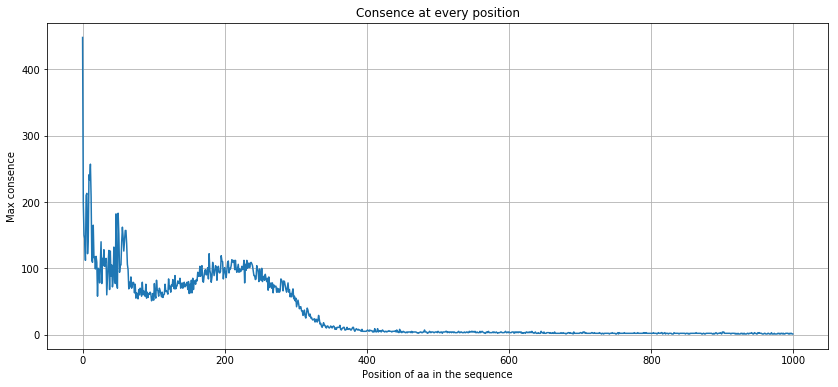

In [7]:
plt.figure(figsize=(14, 6))
plt.plot(best_len[0:1000])
plt.title('Consence at every position')
plt.ylabel('Max consence')
plt.xlabel('Position of aa in the sequence')
plt.grid()
plt.show()
#MAQSKSNPPQVPSGWKAVFDDEYQTWYYVDLSTNSSQWEPPRGTTWPRPKGPPPGVNNEKSSRQQADQAPPPYSSQSTPQVQAGAQAQQPRYYQPQQPQYPQYPQQQRYYPQQAPMPAAAPQQAYYGTAPSTSKGSGHGGAMMGGLLGVGAGLLGGAMLEHAFDDHNYDGPDTVVVENNYYGDDAGGSDGGFDDAGGFDGGFDDGFDGSDF

## HMMER Functions

In [7]:
"""
Check if there are proteins in the positive test set for HMM that are also in the training set ('the blast result used 
for the MSA and for the building of the HMM'). AKA: Check if there are proteins that are in both the training and the test set.
"""

# Get the 'training set' and the 'test set'
training_prot = fasta_to_dict(path = 'data/blast.fasta')
test_prot = fasta_to_dict(path = 'data/human.fasta')

# Get the the training and the test sequences
train_seq, test_seq = set(training_prot.values()), set(test_prot.values())

# Check if there is any sequence in test that is also in train
proteins_found = set()              # Here we insert any proteins found in both the sets
n = 0                               # Counter of proteins found in both
for seq in test_seq:
    if seq in train_seq:
        proteins_found.append(seq)  # If we found a double we insert in a list
        n += 1                      # Increment the counter 
        print('A protein in the test set has been found also in the test set: {}'.format(seq))

# Print the results
if n == 0:
    print('No proteins found in both training and test set!')
else:
    print('{} have been found in both training and test set.'.format(n))

No proteins found in both training and test set!


In [8]:
"""
HMM Result Parser: take as input an HMM_domtblout file and create a dictionary with keys the target-name of the
significant proteins.
Every key is a has a value a dictionary with as key the domain number and as value some statistics about the results of the HMM
"""
def hmm_parser_to_dict(path, is_df = False):
    with open(path) as results:
        # Analyze HMM model
        # Init dict
        my_dict = {}
        ineer_keys = ['c']
        # Parse result table 
        for lines in results:
            if lines[0:2] == 'sp':
                line = lines.split()
                key = line[0].split('|')
                if key[1] not in my_dict.keys():
                    n = 1
                    my_dict[key[1]] = {'domain_{}'.format(n): {'c-evalue': line[11],
                                                               'i-evalue': line[12], 
                                                               'score': line[13]}}
                    n+=1
                else:
                    my_dict[key[1]]['domain_{}'.format(n)] = {'c-evalue': line[11], 'i-evalue': line[12], 'score': line[13]}
                    n+=1
        # If is_df is True we return a DataFrame
        if is_df:
            values = {(outer, inner): values for outer, innerDict in hmm_results.items() for inner, values in innerDict.items()}
            return pd.DataFrame(values).transpose()
        # If is_df is False we return a dict
        else:
            return my_dict
    

"""
Parse the HMM results such that we return a Dataframe with multindex (ID, domain number) and values some statistics about
the domain.
"""
def hmm_parser(path):
    with open(path) as results:
        # Analyze HMM model
        # Columns
        results.__next__()
        col = results.__next__().split()[14:-3]
        col[4], col[5] = 'hmm_{}'.format(col[4]), 'hmm_{}'.format(col[5])
        col[6], col[7] = 'ali_{}'.format(col[6]), 'ali_{}'.format(col[7])
        col[8], col[9] = 'env_{}'.format(col[8]), 'env_{}'.format(col[9])
        # Init MultiIndex and Values
        outer, inner = [], []
        values = []
        # We cycle in the rows to get ID, domain and values
        for lines in results:
            if lines[0:2] == 'sp':
                line = lines.split()
                # Here we get the values
                values.append(line[11:22]) 
                # Here we get the multindex
                key = line[0].split('|')[1]
                if key not in outer:
                    n = 1
                    outer.append(key) 
                    inner.append(1)
                else:
                    outer.append(key)
                    inner.append(n)
                n += 1
        # Create the MultiIndex
        arrays = [outer, inner]
        index = pd.MultiIndex.from_arrays(arrays, names=('ID', 'Domain'))
        # Return df
        df = pd.DataFrame(values, columns=col, index=index)
        # Transform values from str to float
        df.iloc[:, :4] = df.iloc[:, :4].applymap(lambda x: float(x))
        return df          
                
    
df = hmm_parser(path='results//HMM_domtblout_all')
df[df['i-Evalue'] < 0.05]

FileNotFoundError: [Errno 2] No such file or directory: 'results//HMM_domtblout_all'

In [119]:
"""
Parse the PSSM results such that we return a Dataframe with index ID and Bit-Score and E-Value.
"""
def pssm_parser(path):
    with open(path) as results:
        # Analyse pssm model
        while results.__next__()[0:9] != 'Sequences':
            continue
        df = pd.DataFrame()
        
        condition = True
        results.__next__()
        while(condition):
            line = results.__next__().split()
            if len(line) > 0:
                df[line[0]] = [line[-2], line[-1]]
            else:
                condition = False
        df = df.transpose()
        df.columns = ['Bit-Score', 'E-Value']
        return df

pssm_parser(path = 'results//pssm.txt')

,Bit-Score,E-Value
Q8N3X1,53.9,5e-08
Q96J02,52.4,1e-07
O00308,52.0,2e-07
Q9H0M0,50.5,6e-07
Q76N89,47.8,5e-06
Q9H4Z3,46.6,9e-06
Q13526,43.1,3e-05
Q6ZUM4,44.7,4e-05
Q9BYW2,42.4,2e-04


In [124]:
"""
Get the union of the passed proteins of the HMM and PSSM (Get proteins that passed PSSM or HMM).
"""
def ensamble(pssm_path, hmm_path, i_evalue = 0.05):
    # Get PSSM results
    pssm_positive = set(pssm_parser(path = pssm_path).index)
    # Get HMM results
    df_hmm = hmm_parser(path=hmm_path)
    df_hmm = df_hmm[df_hmm['i-Evalue'] < i_evalue]
    hmm_positive =  set([index[0] for index in df_hmm.index])
    # Get the union of the two results
    ensamble_positive = pssm_positive.union(hmm_positive)
    ensamble_dict = {}
    for key in ensamble_positive:
        if (key in pssm_positive) and (key in hmm_positive):
            ensamble_dict[key] = 'in both'
        elif key in pssm_positive:
            ensamble_dict[key] = 'in PSSM'
        else:
            ensamble_dict[key] = ' in HMM'
    return ensamble_dict

ensamble_positive = ensamble(pssm_path='results//pssm.txt', hmm_path='results/HMM_domtblout_all', i_evalue = 0.05)
print('Proteins that passed HMM (i-Evalue < 0.05) or PSSM:\n{}'.format(ensamble_positive))
print('Number of proteins is {}'.format(len(ensamble_positive)))

Proteins that passed HMM (i-Evalue < 0.05) or PSSM:
{'Q6ZUM4': 'in PSSM', 'Q8N3X1': 'in both', 'Q13526': 'in both', 'O60861': ' in HMM', 'Q9H0M0': 'in PSSM', 'O15428': ' in HMM', 'Q96J02': 'in both', 'Q76N89': 'in PSSM', 'O00308': 'in PSSM', 'Q9H4Z3': 'in both', 'Q9BYW2': 'in PSSM', 'Q9H4B6': ' in HMM'}
Number of proteins is 12


In [9]:
"""
Get the sequence of the proteins that passed the ensamble
"""
all_pfam = fasta_to_dict('data//human.fasta')
pfam = {key.split('|')[1]: all_pfam[key] for key in all_pfam}
ensamble_pos = {key: pfam[key] for key in ensamble_positive}
ensamble_pos

NameError: name 'ensamble_positive' is not defined

In [125]:
"""
Cross the significant hits of HMM results (domtblout) with the list of the positive test set (positive_pfam).
Return a set containing a list of target sequence name that passed the HMM but are not in the positive test set
"""
def hmm_false_positive(hmm_result_path, true_positive_path):
    # Get positive target (e.g. data\\positve_pfam)
    true_positive_prot = fasta_to_dict(path=true_positive_path)
    true_positive = set([key.split('|')[1]for key in true_positive_prot.keys()])
    #Get HMM results (e.g. results\\HMM_domtblout)
    positive = set([index[0] for index in hmm_parser(path=hmm_result_path).index])
    false_positive = positive.difference(true_positive)
    return false_positive


"""
Cross the significant hits of PSSM results with the list of the positive test set (positive_pfam).
Return a set containing a list of target sequence name that passed the PSSM but are not in the positive test set
"""
def pssm_false_positive(pssm_path, true_positive_path):
    # Get positive target (e.g. data\\positve_pfam)
    true_positive_prot = fasta_to_dict(path=true_positive_path)
    true_positive = set([key.split('|')[1]for key in true_positive_prot.keys()])
    #Get HMM results (e.g. results\\pssm.txt)
    positive = set(pssm_parser(path=pssm_path).index)
    false_positive = positive.difference(true_positive)
    return false_positive

false_positive = hmm_false_positive(hmm_result_path='results//HMM_domtblout_all', true_positive_path='data//all_pfam.fasta')
print('False Positive of the HMM:\n{}'.format(false_positive))

false_positive = pssm_false_positive(pssm_path='results//pssm.txt', true_positive_path='data//all_pfam.fasta')
print('False Positive of the PSSM:\n{}'.format(false_positive))

False Positive of the HMM:
set()
False Positive of the PSSM:
set()


In [ ]:
"""
Pipeline that start from a MSA file, build an HMM model and test it using a test set. Requires MSA
"""
def hmm_pipeline(msa_path, test_set_path, hmm_model_path, out_file_path, domtblout_path, df_out_path, evalue=0.05):
    """
    Requires: os, pandas as pd
    Required files: the MSA fasta file and the test set fasta file
    
    Input file:
    1. msa_path:       the path of the msa.fasta file (file required). str
    2. test_set_path:  the path of the test_set (file required). str
    3. hmm_model_path: the path where we save the HMM model (file generated). str
    4. out_file_path:  the path where we save the first result table (file generated). str
    5. domtblout_path: the path where we save the second result table (file generated). str
    6. df_out_path:    the path where to save the final DataFrame (file generated). str
    7. evalue:         the maximum e-value that a protein/domain need to have in order to be inserted in the final DataFrame.
                       Default is 0.05. float 
    """
    ### 1. Build the model
    os.system('hmmbuild {} {}'.format(hmm_model_path, msa_path))
    print('Model has been built')
    ### 2. Test the model
    os.system('hmmsearch --domtblout {} -o {} {} {}'.
             format(domtblout_path, out_file_path, hmm_model_path, test_set_path))
    print('Model has been tested')
    ### 3. Get dataframe
    df = hmm_parser(path=domtblout_path)
    df = df[df['i-Evalue'] < 0.05]
    df.to_csv(df_out_path)
    print('DataFrame has been saved')
    print('END')

### ENRICHMENT

In [38]:
"""
Perform Fisher test. An Odd-Ratio above 77 tells us the GO prefers the first dataframe (p-value < 0.05), 
while an Odd-Ratio under 0.013 tells us the GO prefers the second dataframe.
Return a Dataframe with index the GO and values the Odd-Ratio and the p-value.
"""
def fisher_test(df1, df2, col_name_go = 'go_id'):
    
    # Inint dict
    results = {}
    
    # Get the number of occurrances of the GO counts
    dict1, dict2 = dict(df1[col_name_go].value_counts()), dict(df2[col_name_go].value_counts())
    
    # Compute the intersaction of the GO terms
    key_intersection = set(dict1.keys()).intersection(set(dict2.keys()))
    
    for key in key_intersection:
        ### 1. Set frequencies
        # Number of occurrences of the specific GO term in DF1   
        tp = dict1[key]
        # Number of occurrences of the specific GO term in DF2
        tn = dict2[key]
        # Number of GO terms that are different from the specific one in DF1
        fp = sum(dict1.values()) - tp
        # Number of GO terms that are different from the specific one in DF2
        fn = sum(dict2.values()) - tn
        # 2. Perform Fisher Exact Test
        fisher_results = fisher_exact([[tp, tn],[fp, fn]])
        # 3. Save results
        results.setdefault(key, {'OddRatio': fisher_results[0], 'p-value': fisher_results[1]})
    
    # Return the DataFrame
    return pd.DataFrame(results).transpose()

In [112]:
"""
To retrieve the GO that are parents, we cycle over ontology["graphs"][0]["edges"] which is a list of dictionary.
Every dictionary is about a GO id (sub) with a relation (pred) with another GO (obj).
We create a dictionary (parents) with as keys the sons and as values the parents. 
"""
def get_parents(ontology):
    parents = {}  # {GO_id(son) : list of GO_id (parents)}
    for edge in ontology["graphs"][0]["edges"]:
        # select only is_a edges
        if edge["pred"] == "is_a":
            parents.setdefault(edge["sub"].split("_")[1], []).append(edge["obj"].split("_")[1])
    return parents

"""
Here we cycle over the nodes to obtain a dictionary of GO_id with as value a description.  
- ontology["graphs"][0]["nodes"] is a list of dictionary with dict_keys(['id', 'meta', 'type', 'lbl'])
- ontology["graphs"][0]["nodes"][1]['lbl'] is the value (e.g: "endocytosed synaptic vesicle processing via endosome")
"""
def get_labels(ontology):
    labels = {}  # {term (GO_id): definition}
    for node in ontology["graphs"][0]["nodes"]:
        # exclude obsolete terms
        if "GO_" in node["id"] and "deprecated" not in node["meta"]:
            go_id = node["id"].split("_")[1]
            labels[go_id] = node["lbl"]
    return labels

"""
Build an ancestors dictionary with as key an GO_id and as value a list of GO_id which are the ancestors of the key.
Return ancestors = {GO_id : list of ancestor GO_ids}
"""
def get_ancestors(ontology):
    nodes = get_labels(ontology).keys()
    parents = get_parents(ontology)
    ancestors = {}
    for node in nodes:
        node_ancestors = []
        node_parents = parents.get(node)
        # Loop parent levels until no more parents
        while node_parents:
            node_ancestors.extend(node_parents)
            # Get the parents of current parents (1 level up)
            node_parents = [term for parent in node_parents for term in parents.get(parent, [])]
        ancestors[node] = node_ancestors
    return ancestors

"""
Build a dictionary for the children (similar to the ancestors one)
Return {node : list_of_children}, leaf terms are not keys.
"""
def get_children(ontology):
    ancestors = get_ancestors(ontology)
    children = {}  
    for node in ancestors:
        for ancestor in ancestors[node]:
            children.setdefault(ancestor, set()).add(node)
    return children

"""
Calculate the minimum depth (distance from the closest root) of each term
"""
def get_depth(ontology):
    # Identify nodes with no predecessors
    nodes, parents = get_labels(ontology).keys(), get_parents(ontology)
    roots = set(nodes) - set(parents.keys())
    # Init the dictionary
    depth = {}
    for node in nodes:
        c = 0
        # Get parents of the node, return None if node is a root
        node_parents = parents.get(node)
        while node_parents:
            c += 1
            # Break the loop if the root is among parents
            if roots.intersection(set(node_parents)):
                break
            # Get the parents of current parents (1 level up)
            node_parents = [term for parent in node_parents for term in parents.get(parent, [])]
        depth[node] = c
    return depth


"""
Function that assign to every GO terms the minimum p-value between its own p-value and the p-values of their children. 
"""
def transmit_pvalue(enrichment, ontology):
    # 1. Get the children of every GO term
    children_dict = get_children(ontology)
    # 2. For every GO in our enrichment dataset we assign to it the minimum p-value of its children 
    for go_id in enrichment.index:
        # Check if the GO term has child
        if children_dict.get(go_id):
            # Retrieve the set of the p-values of all its children
            pvalues = enrichment['p-value'][enrichment.index.isin(children_dict[go_id])]
            # Check we have some children in the dataset. Otherwise we have an empy set 'pvalues'
            if list(pvalues.values):
                # Check if the mimimum pvalue is actually lower than the ancestor one
                min_pvalue = pvalues.min()
                if min_pvalue < enrichment['p-value'][enrichment.index == go_id].values[0]:
                    # If all the conditions are True we assign the minimum pvalue
                    enrichment['p-value'][enrichment.index == go_id] = min_pvalue
    return enrichment
        
    

"""
Pipeline for the enrichment test. Take as input two dataframe and the onotlogy file.
Return a Dataframe with as index the GO_ids and values:
1. the p-value and Odd-Ration of the Fisher exact test,
2. the depth computed from the ontology file
3. the description of the GO_ids
"""
def enrich(df1, df2, ontology, col_name_go = 'go_id', col_name_descr='go_descr'):
    # 1. Get Fisher results
    df = fisher_test(df1, df2, col_name_go=col_name_go)
    # 2. Get Depth
    depth = get_depth(ontology)
    # 3. Get description
    labels = get_labels(ontology)
    # 4. Update dataframe
    labels_, depth_ = [], []
    for go_id in df.index:
        labels_.append(labels[go_id])
        depth_.append(depth[go_id])
    df['depth'] = depth_
    df[col_name_descr] = labels_
    # 5. Return dataframe 
    return df

"""
Filter the enrich dataframe by taking out GO_terms with high p-value or high depth
"""
def enrich_filter(df, max_pvalue=0.05, max_depth=5):
    df_filter = df[(df['p-value'] < max_pvalue) & (df['depth'] < max_depth)]
    df_filter['score'] = np.log(1/df['p-value'])
    return df_filter
     
"""
Create the word cloud of the description of the enriched dataframe, using as frequencies the inverse of p-value  
"""
def word_cloud(df, col_name, col_score, *args, **kwargs):
    return WordCloud(*args, **kwargs).generate_from_frequencies({
        row[col_name]: row[col_score] for i, row in df.iterrows()
    })

#### Enrichment examples

In [113]:
# Parse the gene ontology
with gzip.open("data/go/go.json.gz") as f:
    ontology = json.load(f)
    
all_go= pd.read_table('data/go.csv', dtype={'entry_ac': str, 'go_id': str, 'go_descr': str})
original_df = pd.read_csv('results/ensamble/ensamble_df.csv', index_col=[0])
original_go = all_go[all_go.entry_ac.isin(original_df.index)]
print('Number of rows in all: {}'.format(all_go.shape[0]))
print('Number of rows in original: {}'.format(original_go.shape[0]))
original_go.head()

Number of rows in all: 265966
Number of rows in original: 932


,entry_ac,go_id,go_descr
5869,Q9H4A3,0005737,cytoplasm
5870,Q9H4A3,0005829,cytosol
5871,Q9H4A3,0016020,membrane
5872,Q9H4A3,0005524,ATP binding
5873,Q9H4A3,0019869,chloride channel inhibitor activity


In [114]:
enrich_result = enrich(df1=original_go, df2=all_go, 
                       ontology=ontology, 
                       col_name_descr='go_descr',
                       col_name_go='go_id')
enrich_result = transmit_pvalue(enrichment=enrich_result, ontology=ontology)
enrich_result = enrich_filter(df = enrich_result, max_depth=4, max_pvalue=0.05)
print('Number of GO passed: {}'.format(enrich_result.shape[0]))
enrich_result.head()

C:\Users\fgrim\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of GO passed: 59


C:\Users\fgrim\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,OddRatio,p-value,depth,go_descr,score
0044241,47.611887,0.024189,3,lipid digestion,3.721838
0098882,71.418367,0.017338,3,structural constituent of presynaptic active zone,4.054828
0030157,40.810035,0.027597,3,pancreatic juice secretion,3.590046
0035556,2.311807,0.004646,3,intracellular signal transduction,5.371852
0003755,13.299475,0.010918,3,peptidyl-prolyl cis-trans isomerase activity,4.517338


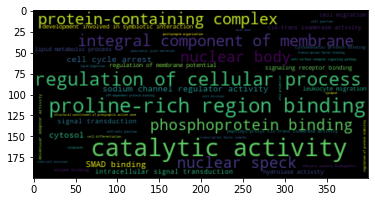

In [115]:
plt.imshow(word_cloud(df=enrich_result, col_name='go_descr', col_score='score'), interpolation='bilinear')